# Short Term Rentals - Exploratory Data Analysis

Now we're going to see what we've imported. As with the previous notebook let's import py2neo and pandas:

In [61]:
%matplotlib notebook

from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [62]:
graph = Graph("bolt://localhost", auth=("neo4j", "neo"))

Now we can run the following query to check how many nodes our database contains:

In [63]:
query = """
CALL db.schema() 
"""

graph.run(query).data()

[{'nodes': [(_-9:Amenity {constraints: ['CONSTRAINT ON ( amenity:Amenity ) ASSERT amenity.name IS UNIQUE'], indexes: [], name: 'Amenity'}),
   (_-11:User {constraints: ['CONSTRAINT ON ( user:User ) ASSERT user.id IS UNIQUE'], indexes: [], name: 'User'}),
   (_-7:Listing {constraints: ['CONSTRAINT ON ( listing:Listing ) ASSERT listing.id IS UNIQUE'], indexes: [], name: 'Listing'}),
   (_-10:Host {constraints: ['CONSTRAINT ON ( host:Host ) ASSERT host.id IS UNIQUE'], indexes: [], name: 'Host'}),
   (_-12:Review {constraints: ['CONSTRAINT ON ( review:Review ) ASSERT review.id IS UNIQUE'], indexes: [], name: 'Review'}),
   (_-8:Neighborhood {constraints: ['CONSTRAINT ON ( neighborhood:Neighborhood ) ASSERT neighborhood.id IS UNIQUE'], indexes: [], name: 'Neighborhood'})],
  'relationships': [(Listing)-[:IN_NEIGHBORHOOD {}]->(Neighborhood),
   (Host)-[:HOSTS {}]->(Listing),
   (Review)-[:REVIEWS {}]->(Listing),
   (User)-[:WROTE {}]->(Review),
   (Listing)-[:HAS {}]->(Amenity)]}]

This query returns all the labels in the database, any constraints they have, as well as relationship types.

We could also run this query in the Neo4j Browser if we want to see a visual representation:

<img align="left" src="images/airbnb-graph.svg" width="500px" />

In [65]:
query = """
MATCH () 
RETURN COUNT(*) AS nodeCount
"""

graph.run(query).to_data_frame()

,nodeCount
0,1978892


Let's drill down a bit. What types of nodes do we have?

In [15]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Amenity,127
1,Neighborhood,224
3,Host,40309
0,Listing,50914
4,User,877779
5,Review,1009539


We can visualize this counts using matplotlib with the following code:

<IPython.core.display.Javascript object>


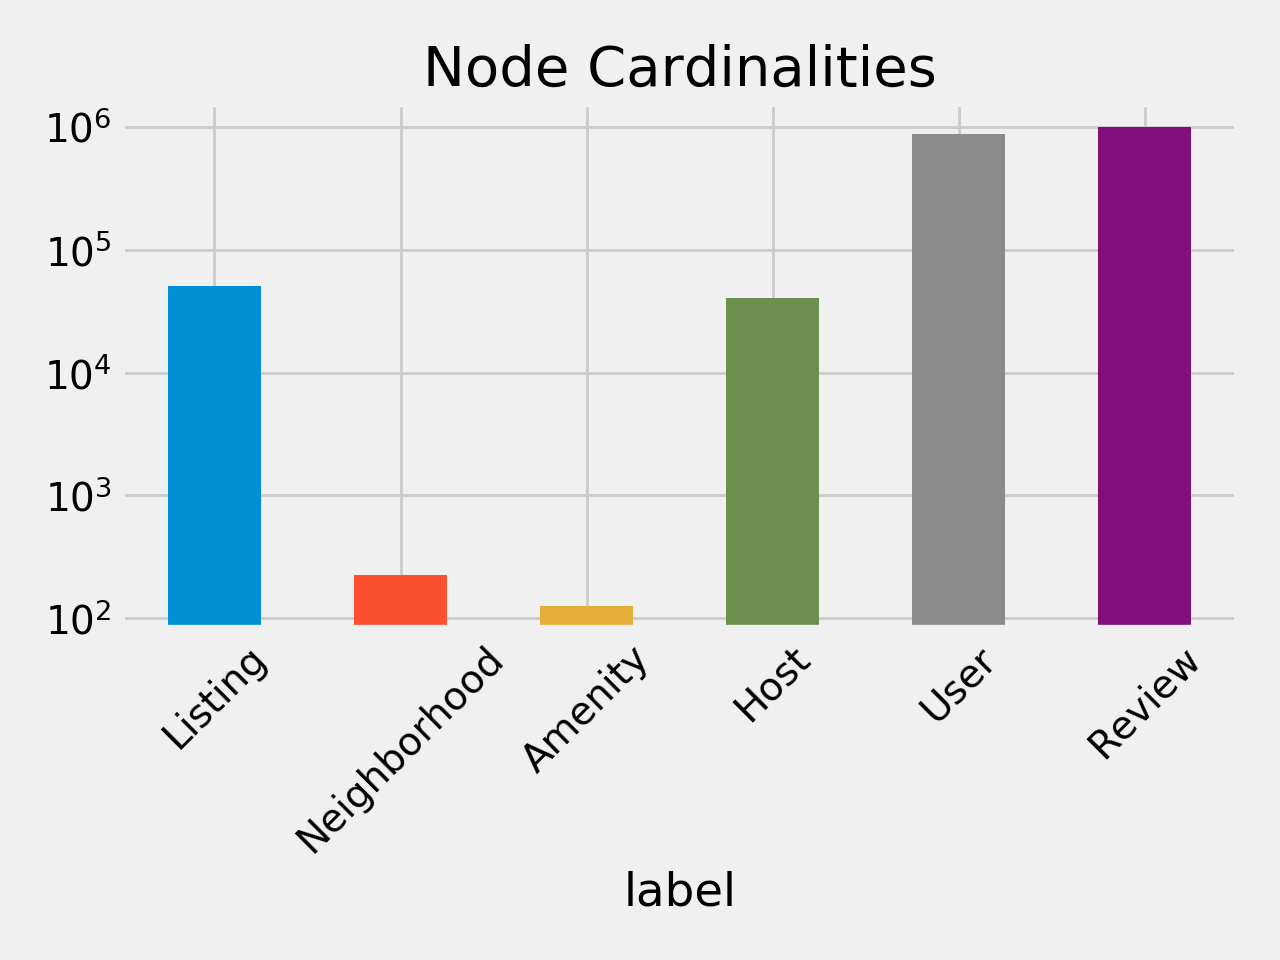

In [66]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And what types of relationships?

In [67]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
0,IN_NEIGHBORHOOD,50914
2,HOSTS,50914
1,HAS,981512
3,WROTE,1009539
4,REVIEWS,1009539


We can visualize this counts using matplotlib with the following code:

<IPython.core.display.Javascript object>


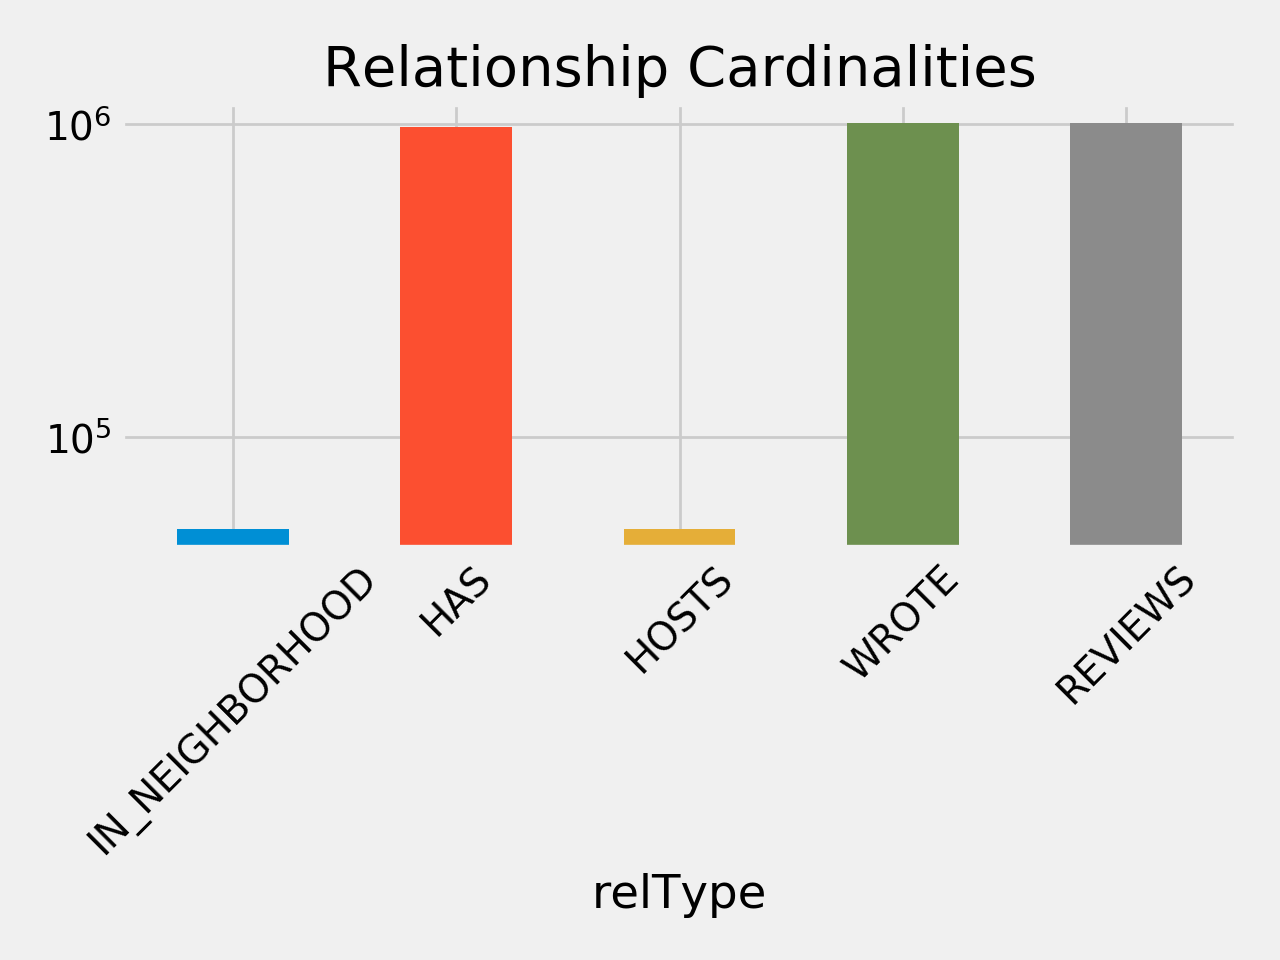

In [68]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the neighborhood data:

In [26]:
exploratory_query = """
MATCH (n:Neighborhood)<-[:IN_NEIGHBORHOOD]-(l:Listing)-[:HAS]->(a:Amenity) 
RETURN n.name AS neighborhood, l.name AS name, collect(a.name) AS amenities, l.price AS price 
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,amenities,name,neighborhood,price
0,"[Hot water, Bed linens, Shampoo, Hangers, Carb...",Spacious room in Harlem sanctuary.,Harlem,45.0
1,"[TV, Cable TV, Internet, Wifi, Kitchen, Elevat...","Marilyn's Home Stay 1, Brooklyn, NY",Flatbush,70.0
2,"[Air conditioning, Kitchen, TV, Wifi, Hangers,...",Clean cozy room 10 min away from Manhattan,Long Island City,43.0
3,"[TV, Cable TV, Wifi, Air conditioning, Kitchen...",Stay in the Heart of Lincoln Square,Upper West Side,142.0
4,"[Wheelchair accessible, Air conditioning, Wifi...","5* Views, Terrace, 2BR2B, Modern Luxury, Gym, ...",Long Island City,379.0
5,"[Dryer, Smoke detector, Essentials, Hangers, A...",Nice Studio in safe area,Concourse,55.0
6,"[Indoor fireplace, Kitchen, Air conditioning, ...",Unique Designer 1BR in Best NYC Neighborhood,West Village,300.0
7,"[Internet, Laptop friendly workspace, Essentia...",Sunny Brooklyn 2BR w/ HUGE terrace!,Bushwick,125.0
8,"[translation missing: en.hosting_amenity_50, L...",Large 1BR in Heart of LES,Lower East Side,245.0
9,"[Iron, Hair dryer, Essentials, Fire extinguish...",1 Bedroom Apt in Chelsea,Chelsea,200.0


What does the distribution of prices in the dataset look like? We can use the `describe` function to work this out:

In [54]:
query = """
MATCH (l:Listing)
RETURN l.price AS price
"""

price_df = graph.run(query).to_data_frame()
price_df.describe()

,price
count,50636.000000
mean,139.611284
std,112.610514
min,0.000000
25%,69.000000
50%,105.000000
75%,175.000000
max,999.000000


This returns some descriptive statistics that allow us to get an understanding of how prices are distributed. We can see that the average price is 139 per night, but the maximum price is 999 - there's clearly a lot of variation in prices!

<IPython.core.display.Javascript object>


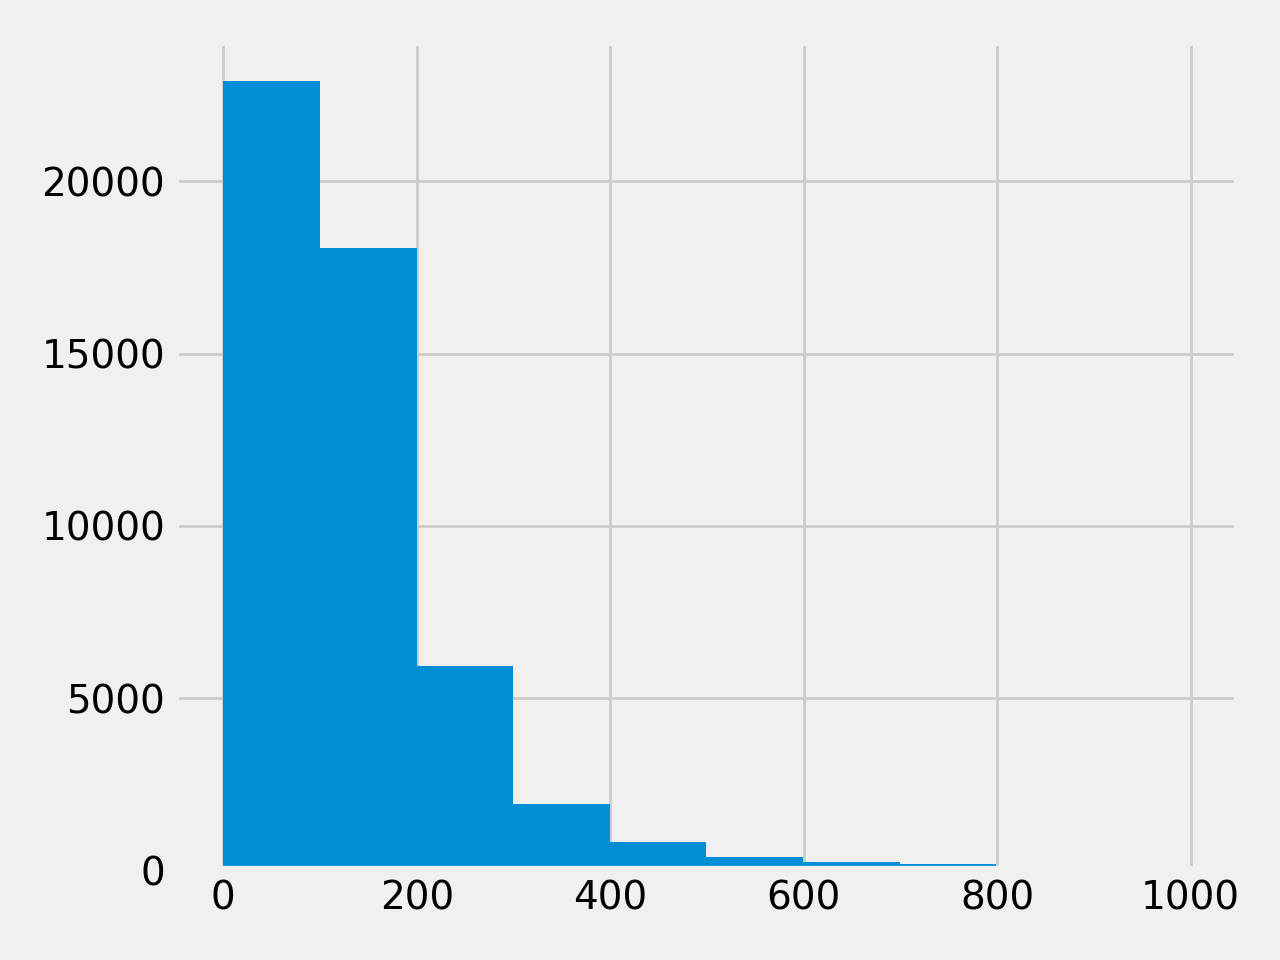

In [59]:
plt.hist(price_df['price'].dropna())
plt.tight_layout()
plt.show() 

We have a very long tail going on here - the majority of listings are priced at under 200, but then there are a few properties that cost much more than this.

What are the most expensive places to live?

In [30]:
query = """
MATCH (l:Listing)-[:IN_NEIGHBORHOOD]->(n:Neighborhood)
WITH n, avg(l.price) AS averagePrice
RETURN n.id AS zip, n.name AS neighborhood, averagePrice
"""

price_df = graph.run(query).to_data_frame().sort_values("averagePrice", ascending=False)
price_df.head(10)

,averagePrice,neighborhood,zip
158,750.000000,South Beach,Fort Wadsworth
99,700.000000,Huguenot,Woodrow
1,429.000000,Emerson Hill,Todt Hill
179,303.361582,Tribeca,Tribeca
5,274.500000,The Rockaways,Neponsit
91,266.203192,Midtown,Midtown
215,260.917647,East Village,NoHo
31,259.378378,Flatiron District,Flatiron District
39,250.445983,Soho,SoHo
180,237.996063,None,Theater District


The variation in average price by neighborhood is easier to see in a chart:

<IPython.core.display.Javascript object>


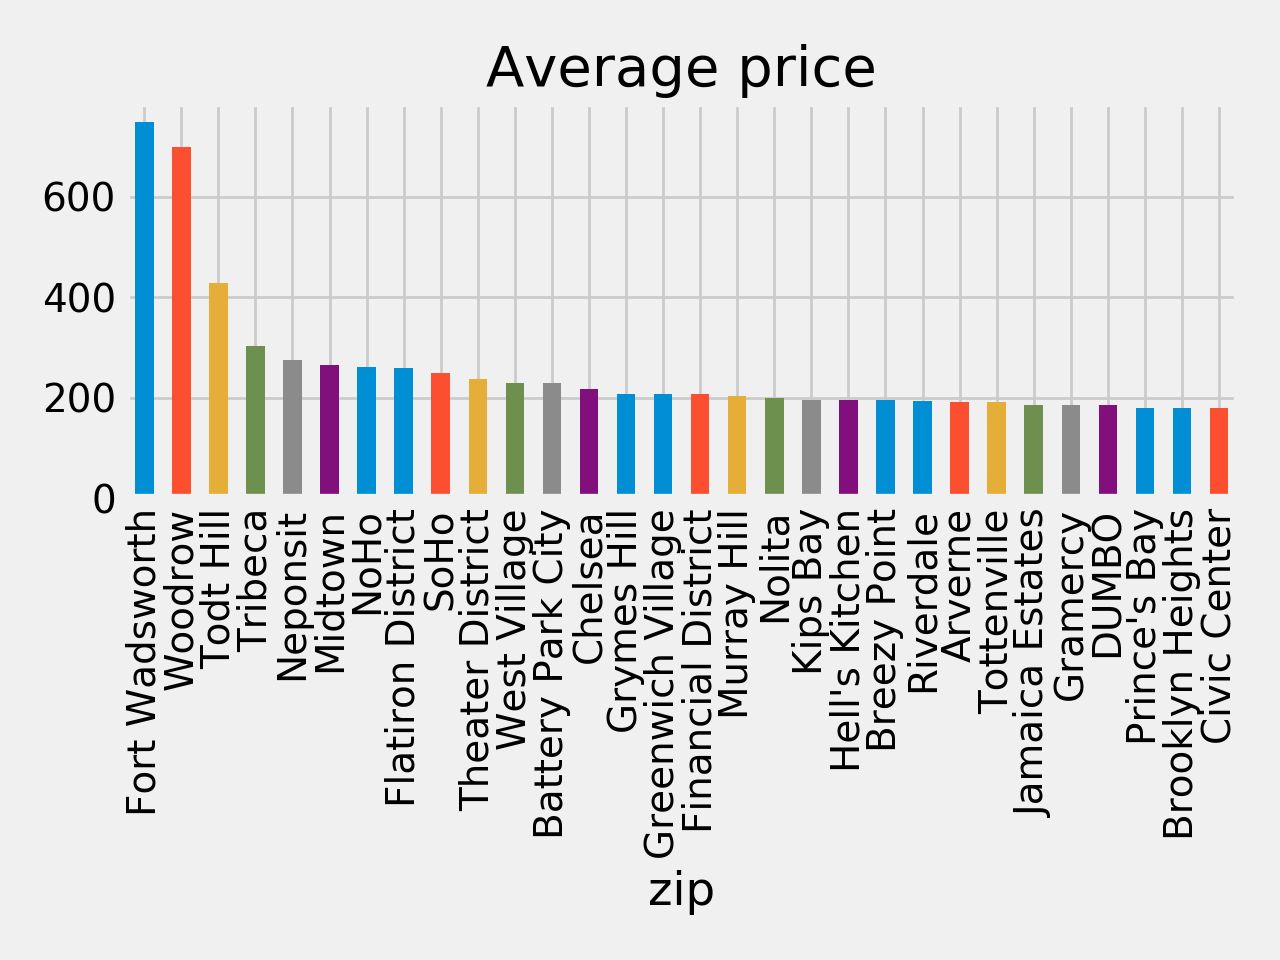

In [46]:
price_df.head(30).plot(kind='bar', x='zip', y='averagePrice', legend=None, title="Average price")
plt.tight_layout()
plt.show()

## Exercise 

* Can you create a similar chart showing the areas which are offering the largest number of bedrooms?
* What about bathrooms?
* What about the number of listings per neighborhood?